# Classificador de tênis (Nike vs Adidas)

In [210]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## Carregamento de dados dos datasets.

In [211]:
def datasetLoader(data_dir, batch_size):
    # antes do data agumentation -> transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomResizedCrop(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
    

    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    val_dir = os.path.join(data_dir, "Validation")

    train_data = ImageFolder(root=train_dir, transform=transform)
    test_data = ImageFolder(root=test_dir, transform=transform)
    val_data = ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

In [212]:
data_dir = "Dataset"
train_loader, test_loader, val_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(train_loader.dataset.classes)
print(device)

cuda:0


In [213]:
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")
print(f"Número de amostras de validação: {len(val_loader.dataset)}")
print("Classes no conjunto de treinamento:")
print(train_loader.dataset.classes)

Número de amostras de treinamento: 459
Número de amostras de teste: 50
Número de amostras de validação: 55
Classes no conjunto de treinamento:
['adidas', 'nike']


In [214]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = nn.Linear(2048, num_classes)
resnet = resnet.to(device)

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Métodos 

### Matriz de confusão

In [215]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

### Acurácia

In [216]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

### Recall

In [217]:
def recall(model, loader):
    model.eval()
    total_positives = len(loader.dataset.targets)
    correct_positives = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)

            correct_positives += (predicted == labels).sum().item()

    if total_positives == 0:
        return 0
    else:
        return correct_positives / total_positives * 100

In [218]:
def precision(model, loader):
    model.eval()
    total_positive_predictions = 0
    correct_positive_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_positive_predictions += (predicted == 1).sum().item()
            correct_positive_predictions += ((predicted == 1) & (labels == 1)).sum().item()
            total_predictions += labels.size(0)

    if total_positive_predictions == 0:
        return 0
    else:
        precision = correct_positive_predictions / total_positive_predictions
        return precision * 100


### Validação

In [219]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss +=loss
    return val_loss/len(loader)

### Regularização

l1_lambda e l2 lambda são os pesos/intensidade que a regularização aplicará no modelo.

In [220]:
def l1_regularization(model, l1_lambda, device):
    l1_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L1 dos parâmetros e somando-as
        l1_reg += torch.norm(param, 1)
    # Multiplicando pela lambda para obter o termo de regularização L1
    return l1_lambda * l1_reg

In [221]:
def l2_regularization(model, l2_lambda, device):
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L2 dos parâmetros e somando suas raízes quadradas
        l2_reg += torch.norm(param, 2) ** 2
    # Multiplicando pela lambda e raiz quadrada para obter o termo de regularização L2
    return l2_lambda * torch.sqrt(l2_reg)

### Treinamento

In [222]:
def train(model, trainloader, testloader, optimizer, criterion, epochs, l1_lambda, l2_lambda):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            l1_reg = l1_regularization(model, l1_lambda, device)
            loss += l1_reg
            l2_reg = l2_regularization(model, l2_lambda, device)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = validation(model, testloader, criterion)
        print(f'Epoch: {epoch+1} | Loss: {running_loss/len(trainloader)} | Val Loss: {val_loss}')

## Registro de evoluções nos modelos
- 1º modelo era treinado com apenas 3 épocas e com learning rate de 0,001. **Acurácia de 70%**.
- 2º modelo subimos o número de épocas para 30 (número baseado nos modelos analisados da referência 1) e ajustamos o learning rate para 0,0001. **Acurácia de 88%**.
- 3º modelo inserimos regularização L1 e L2 com peso da regularização de 0,01. **Acurácia caiu para 76%**
- 4º modelo ajustamos os parâmetros de pesos da regularização L1 e L2 para de 0,0001. **Acurácia de 90%**

Referências:  
1 - https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset/code

In [223]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
l1_lambda = 0.0001
l2_lambda = 0.0001
epochs = 30

## Treinamento

In [224]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs=epochs, l1_lambda=l1_lambda, l2_lambda=l2_lambda)

 97%|█████████▋| 38/39 [00:13<00:00,  2.90it/s]c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 39/39 [00:13<00:00,  2.83it/s]


Epoch: 1 | Loss: 0.4223478805178251 | Val Loss: 1.1621726751327515


100%|██████████| 39/39 [00:13<00:00,  2.84it/s]


Epoch: 2 | Loss: 0.23908608072461227 | Val Loss: 0.47943755984306335


100%|██████████| 39/39 [00:12<00:00,  3.01it/s]


Epoch: 3 | Loss: 0.2915422426871 | Val Loss: 0.49639907479286194


100%|██████████| 39/39 [00:13<00:00,  2.90it/s]


Epoch: 4 | Loss: 0.258840677782129 | Val Loss: 0.6434466242790222


100%|██████████| 39/39 [00:13<00:00,  2.87it/s]


Epoch: 5 | Loss: 0.17472739823353597 | Val Loss: 0.6676902770996094


100%|██████████| 39/39 [00:13<00:00,  2.88it/s]


Epoch: 6 | Loss: 0.20236977187391275 | Val Loss: 0.5977053046226501


100%|██████████| 39/39 [00:13<00:00,  2.97it/s]


Epoch: 7 | Loss: 0.10710250581495273 | Val Loss: 0.7168561220169067


100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


Epoch: 8 | Loss: 0.10718619665847375 | Val Loss: 0.20801575481891632


100%|██████████| 39/39 [00:13<00:00,  2.95it/s]


Epoch: 9 | Loss: 0.11434427245209615 | Val Loss: 0.22941628098487854


100%|██████████| 39/39 [00:13<00:00,  2.88it/s]


Epoch: 10 | Loss: 0.09415258221232738 | Val Loss: 0.7204878330230713


100%|██████████| 39/39 [00:13<00:00,  2.96it/s]


Epoch: 11 | Loss: 0.1946908842640905 | Val Loss: 0.7877001166343689


100%|██████████| 39/39 [00:13<00:00,  2.88it/s]


Epoch: 12 | Loss: 0.2022521044485844 | Val Loss: 0.453432559967041


100%|██████████| 39/39 [00:13<00:00,  2.79it/s]


Epoch: 13 | Loss: 0.2272447146093234 | Val Loss: 0.42323365807533264


100%|██████████| 39/39 [00:13<00:00,  2.83it/s]


Epoch: 14 | Loss: 0.2046438694382325 | Val Loss: 0.3329326808452606


100%|██████████| 39/39 [00:13<00:00,  2.90it/s]


Epoch: 15 | Loss: 0.16533137494936967 | Val Loss: 0.39255276322364807


100%|██████████| 39/39 [00:13<00:00,  2.97it/s]


Epoch: 16 | Loss: 0.1255855974383079 | Val Loss: 0.35297438502311707


100%|██████████| 39/39 [00:13<00:00,  2.88it/s]


Epoch: 17 | Loss: 0.14517910641212112 | Val Loss: 0.6208309531211853


100%|██████████| 39/39 [00:13<00:00,  2.90it/s]


Epoch: 18 | Loss: 0.11037510471084179 | Val Loss: 0.28500694036483765


100%|██████████| 39/39 [00:13<00:00,  2.87it/s]


Epoch: 19 | Loss: 0.08781892236453505 | Val Loss: 0.5891388058662415


100%|██████████| 39/39 [00:13<00:00,  2.96it/s]


Epoch: 20 | Loss: 0.1063416169072764 | Val Loss: 0.7161462306976318


100%|██████████| 39/39 [00:13<00:00,  2.90it/s]


Epoch: 21 | Loss: 0.09387757046482502 | Val Loss: 0.8161396980285645


100%|██████████| 39/39 [00:13<00:00,  2.87it/s]


Epoch: 22 | Loss: 0.08137847555096811 | Val Loss: 0.2832145392894745


100%|██████████| 39/39 [00:13<00:00,  2.89it/s]


Epoch: 23 | Loss: 0.09431732757291637 | Val Loss: 0.413581520318985


100%|██████████| 39/39 [00:13<00:00,  2.91it/s]


Epoch: 24 | Loss: 0.1425129251482968 | Val Loss: 1.544830560684204


100%|██████████| 39/39 [00:13<00:00,  2.84it/s]


Epoch: 25 | Loss: 0.109887941650903 | Val Loss: 0.324146568775177


100%|██████████| 39/39 [00:13<00:00,  2.83it/s]


Epoch: 26 | Loss: 0.10952608055697802 | Val Loss: 0.820733368396759


100%|██████████| 39/39 [00:13<00:00,  2.95it/s]


Epoch: 27 | Loss: 0.06836759000539015 | Val Loss: 0.3979169726371765


100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


Epoch: 28 | Loss: 0.0943659566438351 | Val Loss: 0.8450342416763306


100%|██████████| 39/39 [00:13<00:00,  2.95it/s]


Epoch: 29 | Loss: 0.08411467742198744 | Val Loss: 0.7758395075798035


100%|██████████| 39/39 [00:14<00:00,  2.77it/s]


Epoch: 30 | Loss: 0.11727730939403558 | Val Loss: 0.6261100172996521


## Métricas de avaliação

### Acurácia do modelo

A rede atinge: 92% de acurácia


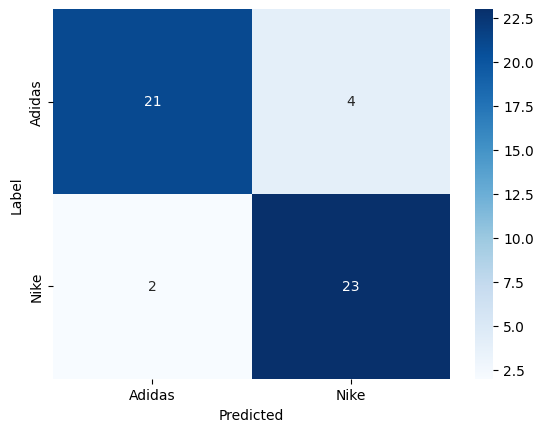

In [225]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
conf_mat = confusion_matrix(resnet, test_loader)

### Recall

In [226]:
print(f'A rede atinge: {round(recall(resnet, test_loader),2)}% de recall')
print(f'A rede atinge: {round(precision(resnet, test_loader),2)}% de precisão')

A rede atinge: 84.0% de recall
A rede atinge: 89.29% de precisão


## Usabilidade de webcam

In [227]:
import cv2

cap = cv2.VideoCapture(0)

img_counter = 0

while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('e'):
            img_name = "WebcamImages/print_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

cap.release()
cv2.destroyAllWindows()

### Predição

In [228]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Adidas' if result == 0 else 'Nike'

### Predição das classes da webcam

In [229]:
from PIL import Image
for filename in os.listdir('WebcamImages'):
    if filename.endswith(".png"):
        x = Image.open('WebcamImages/' + filename).convert('RGB')
        x = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(x)
        print(f'Image: {filename} | Resnet Prediction: {predict(resnet, x)}')